Code to build a basic soil water budget model based on the mathematical equations used by IDC with simplification as here the key is identifying percolation rather than applied water.

In [56]:
# standard python utilities
import os
from os.path import join, exists, dirname, basename
import glob
import sys
import time

import pandas as pd
import numpy as np

import h5py

# standard python plotting utilities
import matplotlib as mpl
import matplotlib.pyplot as plt

# standard geospatial python utilities
import shapely
import geopandas as gpd



In [2]:
doc_dir = os.getcwd()
while os.path.basename(doc_dir) != 'Documents':
    doc_dir = os.path.dirname(doc_dir)
# dir of all gwfm data
gwfm_dir = os.path.dirname(doc_dir)+'/Box/research_cosumnes/GWFlowModel'
gwfm_dir
dis_dir = join(gwfm_dir, 'DIS_data')
uzf_dir = join(gwfm_dir,'UZF_data')

In [469]:
grid_uzf = gpd.read_file(uzf_dir+'/final_grid_uzf/griduzf.shp')

In [470]:
def fill_uzf(uzfvalues, grid_uzf):
#     temp = np.zeros((nrow,ncol))
    temp = np.full((nrow,ncol),np.nan, dtype = uzfvalues.dtype)
    temp[grid_uzf.row.values-1,grid_uzf.column.values-1] = uzfvalues
    return(temp)

In [210]:
soil_dir = join(uzf_dir, 'final_soil_arrays')
soil_Ks = np.loadtxt(soil_dir+'/final_soilKs.tsv', delimiter = '\t')
soil_por = np.loadtxt(soil_dir+'/final_soiln.tsv', delimiter = '\t')/100
soil_eps = np.loadtxt(soil_dir+'/final_soileps.tsv', delimiter = '\t')
# newly created 4/6/2023 to tamp down overestimates of recharge in foothills
soilCN_arr = np.loadtxt(join(soil_dir, 'final_soil_CN.csv'),  delimiter=',')
# temporary fix, CN can never be zero
soilCN_arr = np.where(soilCN_arr==0, soilCN_arr[soilCN_arr>0].min(), soilCN_arr)

In [452]:
# strt_date = pd.to_datetime('2014-10-1')
strt_date = pd.to_datetime('1998-10-1')
end_date = pd.to_datetime('2020-12-31')
nrow, ncol = (100,230)

In [54]:
nrow_p,ncol_p = (100,230)
def dwr_etc(strt_date, end_date):
    nper_tr = (end_date-strt_date).days+1
    natETc = np.zeros((nper_tr,nrow_p,ncol_p))
    agETc = np.zeros((nper_tr,nrow_p,ncol_p))

    per_n = 0 
    for y in np.arange(strt_date.year, end_date.year+1):
        # set start and end date for range for the year to be iterated over
        yr_strt = pd.to_datetime(str(y)+'-01-01')
        yr_end = pd.to_datetime(str(y)+'-12-31')
        # get the length of the date range needed for that year
        yearlen = len(pd.date_range(yr_strt, yr_end))
        if yr_strt < strt_date:
            yr_strt = strt_date
        if yr_end > end_date:
            yr_end = end_date
        yr_len = len(pd.date_range(yr_strt, yr_end))
        # load hdf5 files
        f_irr = h5py.File(join(uzf_dir, "dwr_ETc/irrigated_"+str(y)+".hdf5"), "r")
        agETc[per_n:per_n+yr_len,:,:] = f_irr['array'][str(y)][:][yr_strt.dayofyear-1:yr_end.dayofyear,:,:]
        f_irr.close()
        f_nat = h5py.File(join(uzf_dir, "dwr_ETc/native_"+str(y)+".hdf5"), "r")
        natETc[per_n:per_n+yr_len,:,:] = f_nat['array'][str(y)][:][yr_strt.dayofyear-1:yr_end.dayofyear,:,:]
        f_nat.close()
        per_n += yr_len
    # make sure the return value is separate from the loop
    return(agETc, natETc)

In [453]:
agETc, natETc = dwr_etc(strt_date, end_date)
# net ETc should be ETc from ag and native plants joined
ETc = agETc + natETc

In [454]:
## Potential ETo spatial interpolation from CIMIS
fn = glob.glob(join(uzf_dir,'Cosumnes_dailyET_precip*.csv'))
daily_data = pd.DataFrame()
for file in fn:
    new_data = pd.read_csv(file, index_col = ['Date'], parse_dates = True)
    daily_data = pd.concat((daily_data, new_data))
# units of mm
data_in = daily_data[daily_data['Stn Name']=='Fair Oaks']
# clean up data so columns are by location, units of Precip are in mm
rain_in = data_in.pivot_table(index = 'Date', columns = 'Stn Name', values = 'Precip (mm)')
rain_m = rain_in/1000

# create array for every period of rainfall
rain_df = rain_m[strt_date:end_date].resample('D').interpolate('linear')['Fair Oaks']
rain_arr = np.repeat(np.repeat(np.reshape(rain_df.values, (rain_df.shape[0],1,1)), nrow, axis=1),ncol, axis=2)


If we need to remove ET from each step then we should reduce the number of crops used to simplify calculations unless the code runs quickly for all cells.
- Need to assume initial water content of 0. 
 
* water content can't exceed porosity. It is assumed that θ can be computed to be greater than θT, and the difference between the θ and θT represents the depth of the pond.

Soil water budget equation simplified.  
$ \theta^{t+1} Z^{t+1} = \theta^{t} Z^{t} + \Delta t(P^{t+1} - R_p^{t+1} - P_c^{t+1} - ET^{t+1}) $  
where P = precip, Rp = runoff, P_c = percolation and ET = evapotranspiration  

Percolation equation from IDC per Mualem and van Genuchten.  
$ P_{C}^{t+1} = K_{s} (\frac{\theta^{t+1}}{\theta_T})[1 -(1-(\frac{\theta^{t+1}}{\theta_T})^{1/m})^m]^2 $  
Could convert to the explicit form, by using water content from the previous period.

Runoff based on SCS-CN method  
$ R_p = \frac{1}{\Delta t}\frac{(P\Delta t-0.2S)^2}{P\Delta t+0.8S}$  
$ S = S_{max} (1- \frac{\theta^t - \theta_f/2}{\theta_T - \theta_f/2}) $ when $\theta^t >\theta_f/2 $  
$ S = S_{max}  $ when $\theta^t <\theta_f/2 $  
$ S_{max} = \frac{1000}{CN} - 10 $  
S  is the potential maximum soil retention in inches.  
IDC manual didn't specify this, but per the HEC-HMS guide on CNs the runoff is 0 when precipitation is less than initial abstraction which is assigned as $I_a = rS$  where $0.05 < r <0.2$

In [471]:
soildepth = fill_uzf(grid_uzf.SoilDepth, grid_uzf)
psdi =  fill_uzf(grid_uzf.PSDI, grid_uzf)
# parameter for Mualem, van Genuchten
soil_m = psdi/(psdi+1)
wc_f =  fill_uzf(grid_uzf.w3rdbar, grid_uzf)/100 #field capacity

# for runoff, convert CN from fraction to CN
Smax = (1000/soilCN_arr) - 10

In [455]:
def calc_S(wc, Smax, wc_f, soil_por):
    """ Given an array of water contents return potential soil retention"""
    S = np.zeros((nrow,ncol))
    # when water content is less than 1/2 field capacity, full retention
    S[wc < wc_f/2] = Smax[wc < wc_f/2]
    # wc > porosity then set as porosity for calculations (avoids S >1)
    wc_calc = np.where(wc<soil_por, wc, soil_por)
    # when water content is greater than 1/2 field capacity, partial retention 
    S1 = Smax * (1 - ((wc_calc - wc_f/2)/(soil_por - wc_f/2)))
    S[wc >= wc_f/2]= S1[wc >= wc_f/2]
    # convert S from inches to meters
    S *= (0.3048/12)
    return(S)

In [473]:
tic = time.time()
nper = (end_date-strt_date).days +1
wc = np.zeros((nper+1, nrow, ncol)) # water content, add initial conditions with +1
pc = np.zeros((nper, nrow, ncol)) # percolation
rp = np.zeros((nper, nrow, ncol)) # runoff 
ETa = np.zeros((nper, nrow, ncol)) # actual ET
wb_sum= np.zeros((nper, nrow, ncol)) # water budget check
# time units are days for everything

# -1 starts at IC
for n in np.arange(-1, nper-1):
    # calculate soil saturation as water content can be greater than porosity assuming it represents ponding
    sat = wc[n]/soil_por
    sat  = np.where(sat>1, 1, sat)
    ## Runoff ##
    S = calc_S(wc[n+1], Smax, wc_f, soil_por)
    # calculate runoff only when there is rain, and rain is uniform
    if (rain_arr[n+1]>0).any():
        rp[n+1] = ((rain_arr[n+1] - 0.2*S)**2)/(rain_arr[n+1] + 0.8*S)
    # where rainfall is less than initial abstraction (0.2S) set runoff as 0
    rp[n+1] = np.where(rain_arr[n+1]<0.2*S, 0, rp[n+1])
    ## explicit percolation ##
    pc[n+1] = soil_Ks*(sat)*(1- (1-(sat)**(1/soil_m))**soil_m)**2
    # water budget - all at once would require iteration
#     wc[n+1] = (wc[n]*soildepth + (rain_arr[n+1] - rp[n+1] - pc[n+1] - ETc[n+1]))/soildepth
#     wc[n+1] = np.where(wc[n+1]<0,0,wc[n+1])
    # stepwise water budget, explicit to avoid iteration
    # take away runoff first
    wc[n+1] = (wc[n]*soildepth + (rain_arr[n+1] - rp[n+1]))/soildepth
    # take away ET, add term to prevent going to zero
    ETa[n+1] = np.where(ETc[n+1] <= wc[n+1]*soildepth, ETc[n+1], wc[n+1]*soildepth - 1E-9)
    wc[n+1] = wc[n+1] + (-ETa[n+1])/soildepth
    # take away percolation
    pc[n+1] = np.where(pc[n+1] <= wc[n+1]*soildepth, pc[n+1], wc[n+1]*soildepth - 1E-9)
    wc[n+1] = wc[n+1] + (-pc[n+1])/soildepth
    # check water budget error
    wb_sum[n+1] = (wc[n]-wc[n+1])*soildepth + rain_arr[n+1] - rp[n+1] - ETa[n+1] - pc[n+1]
    if (wb_sum[n+1]>1E-3).any()|(wb_sum[n+1]<-1E-3).any():
        print('WB error exceeds 1E-3',n )
toc = time.time()
print('Run time was %.2f minutes' %((toc-tic)/60))
print('Avg WB error was %.2E m' % wb_sum.sum(axis=(1,2)).mean())

Run time was 0.57 minutes
Avg WB error was 1.10E-14 m


In [378]:
# n = 32
# chk = -(wc[n] - wc[n-1])*soildepth + rain_arr[n] - rp[n] - ETa[n] - pc[n]
# chk.max()
# (wc[n] - wc[n-1])*soildepth

In [419]:
# n=14
# S = calc_S(wc[n], Smax, wc_f, soil_por)
# rp = ((rain_arr[n] - 0.2*S)**2)/(rain_arr[n] + 0.8*S)



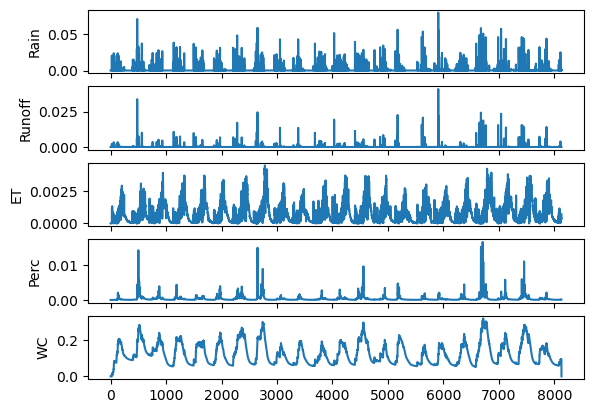

In [474]:
fig,ax = plt.subplots(5,1,sharex=True)
ax[0].plot(rain_arr.mean(axis=(1,2)))
ax[1].plot(rp.mean(axis=(1,2)))
ax[2].plot(ETa.mean(axis=(1,2)))
ax[3].plot(pc.mean(axis=(1,2)))
ax[4].plot(wc.mean(axis=(1,2)))

for n, l in enumerate(['Rain','Runoff','ET','Perc','WC']):
    ax[n].set_ylabel(l)

## Save Output

In [495]:

import h5py

def arr_to_h5(arr, h5_fn):
    # convert arrays of annual rates to hdf5 files individually
    f = h5py.File(h5_fn, "w")
    grp = f.require_group('array') # makes sure group exists
    grp.attrs['units'] = 'meters/day'
    grp.attrs['description'] = 'Each layer of the array is a day in the water year'
    dset = grp.require_dataset('WY', arr.shape, dtype='f', compression="gzip", compression_opts=4)
    dset[:] = arr
    f.close()
    


In [496]:
# years and array index 
years = pd.date_range(strt_date,end_date,freq='AS-Oct')
yr_ind = (years-strt_date).days

# need separte hdf5 for each year because total is 300MB
for n in np.arange(0,len(yr_ind)-1):
    arr = pc[yr_ind[n]:yr_ind[n+1]]
    fn = join(uzf_dir, 'basic_soil_budget',"percolation_WY"+str(years[n].year+1)+".hdf5")
    arr_to_h5(arr, fn)


## Review precip vs percolation

In [475]:
chk = pc.sum(axis=(1,2))*200*200/((0.3048**3)*43560)
chk1 = rain_arr.sum(axis=(1,2))*200*200/((0.3048**3)*43560)

for n in np.arange(0,len(yr_ind)-1):
    print('Perc %.2e'%(chk[yr_ind[n]:yr_ind[n+1]]).sum(), end=', ')
    print('Rain %.2E' %(chk1[yr_ind[n]:yr_ind[n+1]].sum()), end=', ')
    print('Frac %.2f'%(chk[yr_ind[n]:yr_ind[n+1]].sum()/chk1[yr_ind[n]:yr_ind[n+1]].sum()))


Perc 2.97e+04, Rain 3.39E+05, Frac 0.09
Perc 1.67e+05, Rain 4.83E+05, Frac 0.34
Perc 9.77e+04, Rain 3.07E+05, Frac 0.32
Perc 8.21e+04, Rain 3.71E+05, Frac 0.22
Perc 7.85e+04, Rain 3.59E+05, Frac 0.22
Perc 7.86e+04, Rain 3.07E+05, Frac 0.26
Perc 1.36e+05, Rain 4.87E+05, Frac 0.28
Perc 1.70e+05, Rain 5.08E+05, Frac 0.34
Perc 5.03e+04, Rain 2.62E+05, Frac 0.19
Perc 5.22e+04, Rain 2.40E+05, Frac 0.22
Perc 5.83e+04, Rain 3.12E+05, Frac 0.19
Perc 7.91e+04, Rain 3.58E+05, Frac 0.22
Perc 1.65e+05, Rain 5.38E+05, Frac 0.31
Perc 6.49e+04, Rain 3.13E+05, Frac 0.21
Perc 7.11e+04, Rain 2.94E+05, Frac 0.24
Perc 4.45e+04, Rain 2.92E+05, Frac 0.15
Perc 5.40e+04, Rain 2.87E+05, Frac 0.19
Perc 6.80e+04, Rain 3.25E+05, Frac 0.21
Perc 2.34e+05, Rain 7.01E+05, Frac 0.33
Perc 8.90e+04, Rain 4.50E+05, Frac 0.20
Perc 1.69e+05, Rain 5.76E+05, Frac 0.29
Perc 5.45e+04, Rain 3.01E+05, Frac 0.18
